In [18]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from itertools import combinations
from tqdm.notebook import tqdm
from sklearn.tree import plot_tree

In [17]:
# Datafile
df = pd.read_csv("./NA850data_2000-2014.csv")
df.head()

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,LH,Lat,Lon,PtIndex,WaveTrajectory,Time
0,7.060846,7.267001,0.000642,1021.565625,-11.894431,-5.276164,12.888080,25.064459,-35.368896,0,1,2000010100
1,10.865533,9.469151,-0.000444,1015.694375,-12.986907,-2.199314,16.006929,20.454613,-54.790527,18,1,2000010306
2,7.100183,7.474899,-0.000296,1021.084141,-11.230261,-3.172798,-10.217120,24.480576,-36.771637,1,1,2000010103
3,11.154810,9.294266,0.000126,1015.156875,-11.698672,-2.088208,1.020178,19.468901,-55.690735,19,1,2000010309
4,7.068231,7.335827,0.000323,1020.302969,-10.246526,-1.993664,0.511768,24.649042,-37.882874,2,1,2000010106


In [19]:
desc_corr = abs(df.corr('kendall'))[['LH']].sort_values(by='LH', ascending=False)
desc_corr

,LH
LH,1.000000
Omega,0.487346
QV,0.473145
SeaLevPress,0.187259
Lon,0.179262
WaveTrajectory,0.134285
Lat,0.133566
AirTemp,0.131982
Time,0.046707
UWinds,0.038739


In [20]:
LQ = df.LH.quantile(0.25)
UQ = df.LH.quantile(0.75)
bound = 1.5 * (UQ - LQ) #Whisker length * IQR
lower_bound = LQ - bound
upper_bound = UQ + bound
df["Extreme"] = np.where( (df["LH"] > upper_bound) | (df["LH"]  < lower_bound), 1, 0)

In [21]:
data_Y = df["Extreme"]
data_X = df.drop(["Extreme", "LH"], axis=1)

In [22]:
data_X

,AirTemp,QV,Omega,SeaLevPress,UWinds,VWinds,Lat,Lon,PtIndex,WaveTrajectory,Time
0,7.060846,7.267001,0.000642,1021.565625,-11.894431,-5.276164,25.064459,-35.368896,0,1,2000010100
1,10.865533,9.469151,-0.000444,1015.694375,-12.986907,-2.199314,20.454613,-54.790527,18,1,2000010306
2,7.100183,7.474899,-0.000296,1021.084141,-11.230261,-3.172798,24.480576,-36.771637,1,1,2000010103
3,11.154810,9.294266,0.000126,1015.156875,-11.698672,-2.088208,19.468901,-55.690735,19,1,2000010309
4,7.068231,7.335827,0.000323,1020.302969,-10.246526,-1.993664,24.649042,-37.882874,2,1,2000010106
...,...,...,...,...,...,...,...,...,...,...,...
20299,13.976068,9.267782,0.000962,1013.787969,-5.725973,1.024751,23.499479,-48.751160,51,240,2014121321
20300,13.713007,8.729606,-0.000825,1014.931094,-5.089421,3.418641,23.499500,-49.022491,52,240,2014121400
20301,14.085962,9.510149,0.000713,1014.133594,-3.518239,3.075252,23.383141,-49.258881,53,240,2014121403
20302,13.607874,9.221160,-0.000341,1012.970781,-2.101092,4.653747,23.517527,-49.335236,54,240,2014121406


In [23]:
res_combined = []
for index in range(2, len(desc_corr)):
    X_train, X_test, y_train, y_test = train_test_split(data_X[desc_corr.index[1:index]], data_Y, test_size=0.25, random_state=738)
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    res_combined.append(f1_score(y_test, y_pred))
res_combined

[0.5552353506243997,
 0.5436543654365437,
 0.5526802218114603,
 0.550185873605948,
 0.5706570657065706,
 0.5719489981785063,
 0.583180987202925,
 0.6231617647058824,
 0.5894346617238183,
 0.6036036036036035]

In [24]:
combs = []
for x in range(2, len(desc_corr)):
    combs += [list(y) for y in combinations(desc_corr.index[1:], x)]

In [25]:
# Keys will be index from combs list, Values will be F1 score
res_comb = []
for index in range(len(combs)):
    X_train, X_test, y_train, y_test = train_test_split(data_X[combs[index]], data_Y, test_size=0.25, random_state=738)
    dt = DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    res_comb.append(f1_score(y_test, y_pred))

In [26]:
best_index = res_comb.index(max(res_comb))
print("Best F1 score of %f using\n%s" % (res_comb[best_index], str(combs[best_index])))

Best F1 score of 0.628205 using
['Omega', 'QV', 'Lon', 'WaveTrajectory', 'AirTemp', 'Time', 'VWinds']


In [27]:
# Keys will be index from combs list, Values will be F1 score
res_comb = []
for index in range(len(combs)):
    X_train, X_test, y_train, y_test = train_test_split(data_X[combs[index]], data_Y, test_size=0.25, random_state=738)
    dt = DecisionTreeClassifier(max_depth=10)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    res_comb.append(f1_score(y_test, y_pred))

In [28]:
best_index = res_comb.index(max(res_comb))
print("Best F1 score of %f using\n%s" % (res_comb[best_index], str(combs[best_index])))

Best F1 score of 0.665350 using
['Omega', 'WaveTrajectory', 'Lat', 'AirTemp', 'Time', 'VWinds']


In [29]:
# Keys will be index from combs list, Values will be F1 score
res_comb = []
for index in range(len(combs)):
    X_train, X_test, y_train, y_test = train_test_split(data_X[combs[index]], data_Y, test_size=0.25, random_state=738)
    dt = DecisionTreeClassifier(criterion="entropy")
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    res_comb.append(f1_score(y_test, y_pred))

In [30]:
best_index = res_comb.index(max(res_comb))
print("Best F1 score of %f using\n%s" % (res_comb[best_index], str(combs[best_index])))

Best F1 score of 0.628263 using
['Omega', 'Lon', 'WaveTrajectory', 'Lat', 'AirTemp', 'UWinds', 'VWinds']


In [31]:
# Keys will be index from combs list, Values will be F1 score
res_comb = []
for index in range(len(combs)):
    X_train, X_test, y_train, y_test = train_test_split(data_X[combs[index]], data_Y, test_size=0.25, random_state=738)
    dt = DecisionTreeClassifier(criterion="entropy", max_depth=9)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    res_comb.append(f1_score(y_test, y_pred))

In [32]:
best_index = res_comb.index(max(res_comb))
print("Best F1 score of %f using\n%s" % (res_comb[best_index], str(combs[best_index])))

Best F1 score of 0.669941 using
['Omega', 'Lat', 'AirTemp', 'Time']


In [33]:
X_train, X_test, y_train, y_test = train_test_split(data_X[combs[best_index]], data_Y, test_size=0.25, random_state=738)
dt = DecisionTreeClassifier(criterion="entropy", max_depth=9)
dt.fit(X_train, y_train)
# y_pred = dt.predict(X_test)

DecisionTreeClassifier(criterion='entropy', max_depth=9)

[Text(0.47650983146067416, 0.95, 'X[0] <= -0.003\nentropy = 0.477\nsamples = 15228\nvalue = [13665, 1563]'),
 Text(0.2294943820224719, 0.85, 'X[0] <= -0.004\nentropy = 0.956\nsamples = 1817\nvalue = [685, 1132]'),
 Text(0.08820224719101123, 0.75, 'X[0] <= -0.01\nentropy = 0.754\nsamples = 1144\nvalue = [248, 896]'),
 Text(0.020224719101123594, 0.65, 'X[0] <= -0.014\nentropy = 0.31\nsamples = 378\nvalue = [21, 357]'),
 Text(0.008988764044943821, 0.55, 'X[3] <= 2013090240.0\nentropy = 0.058\nsamples = 150\nvalue = [1, 149]'),
 Text(0.0044943820224719105, 0.45, 'entropy = 0.0\nsamples = 121\nvalue = [0, 121]'),
 Text(0.01348314606741573, 0.45, 'X[3] <= 2013095616.0\nentropy = 0.216\nsamples = 29\nvalue = [1, 28]'),
 Text(0.008988764044943821, 0.35, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.017977528089887642, 0.35, 'entropy = 0.0\nsamples = 28\nvalue = [0, 28]'),
 Text(0.03146067415730337, 0.55, 'X[3] <= 2003070528.0\nentropy = 0.429\nsamples = 228\nvalue = [20, 208]'),
 Text

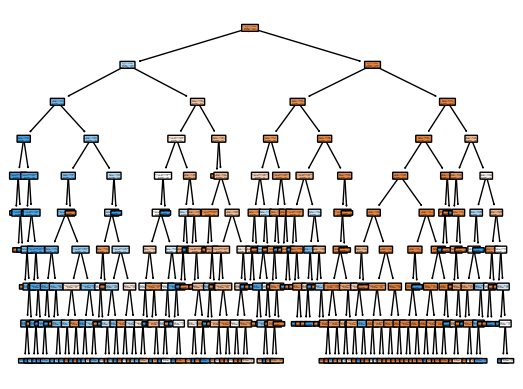

In [34]:
plot_tree(dt,filled = True, 
          rounded = True)